In [ ]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

In [7]:
%%cu
#include<stdio.h>
#include<time.h>

float integrate(int N)
{
float sum = 0;
for(int i = 0; i < N; ++i)
{
float x = (float) i / (float) N;
float fx = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
sum += fx;
}
sum *= 1.0f / (float)N;
return sum;
}

int main(){
    clock_t start, end;
    float calka ; 
    start = clock();
    calka =  integrate(1000);
    end = clock();
    printf("%f\n", calka);
    printf("Time taken: %lf milliseconds\n", (double)(end - start) / (CLOCKS_PER_SEC/1000));
    printf("Time taken: %lf seconds\n", (double)(end - start) / CLOCKS_PER_SEC);
    return 0 ;  
}

0.341423
Time taken: 0.068000 milliseconds
Time taken: 0.000068 seconds



In [8]:
%%cu
#include<time.h>
#include<stdio.h>

float integrate_trapezoidal(int N)
{
    float sum = 0;
    for(int i = 0; i < N-1; ++i)
    {
        float x = (float) i / (float) N;
        float x_next = (float) (i+1) / (float) N;
        float fx = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
        float fx_next = (1.0f / sqrt(2.0f * M_PI)) * exp(-x_next * x_next / 2.0f );
        sum += (fx + fx_next)/2;
    }
    sum *= 1.0f / (float)N;
    return sum;
}


int main(){
     clock_t start, end;
    float calka ; 
    start = clock();
calka = integrate_trapezoidal( 1000);
    end = clock();
    printf("%f\n", calka);
       printf("Time taken: %lf milliseconds\n", (double)(end - start) / (CLOCKS_PER_SEC/1000));
    printf("Time taken: %lf seconds\n", (double)(end - start) / CLOCKS_PER_SEC);

return 0 ; 
}


0.341103
Time taken: 0.060000 milliseconds
Time taken: 0.000060 seconds



In [9]:
%%cu
#include<time.h>
#include<stdio.h>
float integrate_simpson(int N)
{
    float sum = 0;
    for(int i = 0; i < N-1; i+=1)
    {
        float x = (float) i / (float) N;
        float x_mid = (float) (i+1) / (float) N;
        float x_next = (float) (i+2) / (float) N;
        float fx = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
        float fx_mid = (1.0f / sqrt(2.0f * M_PI)) * exp(-x_mid * x_mid / 2.0f );
        float fx_next = (1.0f / sqrt(2.0f * M_PI)) * exp(-x_next * x_next / 2.0f );
        sum +=(fx + 4*fx_mid + fx_next)/6;
}
sum *= 1.0f / (float)N;
return sum;
}

int main(){
      clock_t start, end;
    float calka ; 
    start = clock();

calka = integrate_simpson(1000  );
 end = clock();
    printf("%f\n", calka);
          printf("Time taken: %lf milliseconds\n", (double)(end - start) / (CLOCKS_PER_SEC/1000));
    printf("Time taken: %lf seconds\n", (double)(end - start) / CLOCKS_PER_SEC);


return 0 ; 
}


0.341024
Time taken: 0.090000 milliseconds
Time taken: 0.000090 seconds



In [10]:
%%cu
#include <cuda_runtime.h>
#include<stdio.h>
__global__ void integratorKernel(float *a, int N)
{
int idx = blockIdx.x * blockDim.x + threadIdx.x;
float x = (float)idx / (float)N;
if(idx < N)
a[idx] = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
}
float cudaIntegrate(int N)
{
size_t size = N * sizeof(float);
// alokacja pamieci
 
float* a_h = (float *)malloc(size);
float* a_d ; cudaMalloc((void **) &a_d, size);

int block_size = 256;
int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
integratorKernel <<< n_blocks, block_size >>> (a_d, N);
// kopiuj z device do hosta
cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);

float sum = 0;
for (int i=0; i < N; i++) sum += a_h[i];
sum *= 1.0 / (float)N;;
// saprztanij
free(a_h); cudaFree(a_d);
return sum;
 
 
}

int main(void){
    cudaEvent_t start, stop;
    float x;

    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, 0);
    x = cudaIntegrate(1000 );
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    
    printf("Time taken: %f ms\n", milliseconds);

    float seconds = milliseconds / 1000;
    printf("Time taken: %f s\n", seconds);

    float hours = seconds / 3600;
    printf("Time taken: %f h\n", hours);

    printf("Wartosc calki %f" , x) ;

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0 ; 
}

Time taken: 0.000000 ms
Time taken: 0.000000 s
Time taken: 0.000000 h
Wartosc calki 88150075605556587499079532162318336.000000


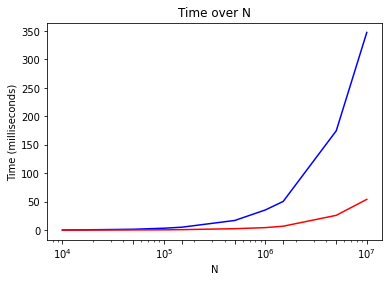

In [11]:
import matplotlib.pyplot as plt

n1 =          [         10000 , 50000     ,  100000  , 150000  , 500000  , 1000000 , 1500000 , 5000000 , 10000000 ]
time_ms_CPU = [   0.333000 , 1.798000 , 3.627000  ,5.383000 , 17.233000 , 35.666000,50.671000 ,174.576000 ,347.298000]
time_ms_GPU = [ 0.289024 , 0.622912 ,0.799488 , 1.110496 , 2.798560 ,  4.657536 ,7.140672 , 26.223295,54.268383 ]

plt.plot( n1, time_ms_CPU,color='blue', label='CPU')
plt.plot(n1 ,time_ms_GPU  , color='red' , label='GPU' )

plt.xscale("log")
plt.xticks(n1)
plt.xlabel('N')
plt.ylabel('Time (milliseconds)')
plt.title('Time over N')
plt.show()

In [12]:
%%cu 
#include<stdio.h>
#include <cuda_runtime.h>
__global__ void integratorKernel(float *a, int N, float h)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = (float)idx / (float)N;
    if(idx < N)
        a[idx] = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
}
float cudaIntegrate(int N)
{

    size_t size = N * sizeof(float);
    // alokacja pamieci
    float* a_h = (float *)malloc(size);
    float* a_d ; cudaMalloc((void **) &a_d, size);
    int block_size = 256;
    int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
    float h = 1.0f / (float)N;
    integratorKernel <<< n_blocks, block_size >>> (a_d, N, h);
    // kopiuj z device do hosta
    cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
    // uzyj metody trapeow
    float sum = (a_h[0] + a_h[N-1]) / 2.0f;
    for (int i=1; i < N-1; i++) sum += a_h[i];
    sum *= h;
    // sprzatnij
    free(a_h); cudaFree(a_d);
    return sum;
}

int main(void){
     cudaEvent_t start, stop;
     cudaEventCreate(&start); 
    cudaEventCreate(&stop);

    cudaEventRecord(start, 0);
   float x = cudaIntegrate( 1000000 );
  cudaEventRecord(stop, 0);

    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("Time taken: %f ms\n", milliseconds);

    float seconds = milliseconds / 1000;
    printf("Time taken: %f s\n", seconds);

    float hours = seconds / 3600;
    printf("Time taken: %f h\n", hours);

    printf("%f" , x) ;

    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    
  return 0 ; 

}

Time taken: 0.000000 ms
Time taken: 0.000000 s
Time taken: 0.000000 h
0.000000


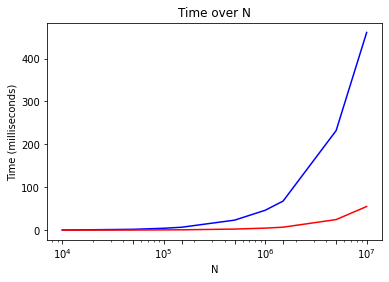

In [13]:
import matplotlib.pyplot as plt

n1 =          [  10000 ,  50000     ,  100000  , 150000  , 500000  , 1000000 , 1500000 , 5000000 , 10000000 ]
time_ms_CPU = [ 0.453000  , 2.167000 , 4.591000, 6.991000 ,23.566000 ,46.543000,67.896000,232.039000 ,460.781000     ]
time_ms_GPU = [ 0.296544 , 0.510400  ,0.806464 , 1.003808 , 2.717088 ,4.960896 ,7.109088 , 24.835840  ,55.288864 ]

plt.plot( n1, time_ms_CPU, color='blue', label='CPU')
plt.plot(n1 ,time_ms_GPU  , color='red' , label='GPU' )

plt.xscale("log")
plt.xticks(n1)
plt.xlabel('N')
plt.ylabel('Time (milliseconds)')
plt.title('Time over N')
plt.show()


In [14]:
%%cu 

#include<stdio.h>
#include <cuda_runtime.h>
__global__ void integratorKernel(float *a, int N, float h)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = (float)idx / (float)N;
    if(idx < N)
        a[idx] = (1.0f / sqrt(2.0f * M_PI)) * exp(-x * x / 2.0f );
}
float cudaIntegrate(int N)
{
 
    size_t size = N * sizeof(float);
    // alokacja pamieci
    float* a_h = (float *)malloc(size);
    float* a_d ; cudaMalloc((void **) &a_d, size);
    int block_size = 256;
    int n_blocks = N/block_size + (N % block_size == 0 ? 0:1);
    float h = 1.0f / (float)N;
    integratorKernel <<< n_blocks, block_size >>> (a_d, N, h);
    // kopiuj z device do hosta 
    cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost);
   

    float sum = a_h[0] + a_h[N-1];
    for (int i=1; i < N-1; i++)
    {
        if (i % 2 == 0)
            sum += 2 * a_h[i];
        else
            sum += 4 * a_h[i];
    }
    sum *= h / 3.0f;
    // sprzatnij
    free(a_h); cudaFree(a_d);
    return sum;
}

int main(void){
     cudaEvent_t start, stop;
     cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, 0);
   float x = cudaIntegrate(10000);
   cudaEventRecord(stop, 0);

    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("Time taken: %f ms\n", milliseconds);

    float seconds = milliseconds / 1000;
    printf("Time taken: %f s\n", seconds);

    float hours = seconds / 3600;
    printf("Time taken: %f h\n", hours);

    printf("%f" , x) ;

    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    
  return 0 ; 

}

Time taken: 0.000000 ms
Time taken: 0.000000 s
Time taken: 0.000000 h
nan


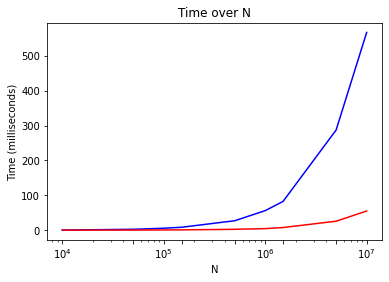

In [15]:
import matplotlib.pyplot as plt

n1 =          [  10000 ,  50000     ,  100000  , 150000  , 500000  , 1000000 , 1500000 , 5000000 , 10000000 ]
time_ms_CPU = [ 0.544000  , 2.691000  , 5.770000 , 8.546000  ,27.207000 ,56.187000, 82.652000 ,287.248000,566.994000      ]
time_ms_GPU = [0.358208 , 0.481376 ,  0.793856 ,1.073440 , 2.688352 ,  4.701952 ,7.723648 ,25.896769 , 55.126686   ]

plt.plot( n1, time_ms_CPU, color='blue', label='CPU')
plt.plot(n1 ,time_ms_GPU  , color='red' , label='GPU' )

plt.xscale("log")
plt.xticks(n1)
plt.xlabel('N')
plt.ylabel('Time (milliseconds)')
plt.title('Time over N')
plt.show()


 **Wydajność**: Programy GPU są znacznie bardziej wydajne niż programy wykorzystujące tylko procesor. Mogą przetwarzać dane znacznie szybciej, co oznacza, że programy GPU mogą obsłużyć więcej danych w krótszym czasie. 

 **Zastosowanie**: Programy GPU są szczególnie przydatne do obliczeń numerycznych, takich jak integracja lub renderowanie grafiki 3D, które wymagają dużej mocy obliczeniowej. 

 **Skalowalność**: Programy GPU są bardziej skalowalne niż programy CPU, co oznacza, że mogą efektywnie wykorzystywać więcej rdzeni i wątków, co pozwala im przyspieszyć obliczenia. Dlatego, gdy musimy przetwarzać duże ilości danych lub obliczać złożone algorytmy, programy GPU mogą być bardziej odpowiednie niż programy CPU.

**Sprzęt**: Aby korzystać z programów GPU, potrzebujemy specjalistycznego sprzętu, takiego jak karta graficzna obsługująca CUDA lub OpenCL. Dlatego przed rozpoczęciem korzystania z takich programów musimy się upewnić, że posiadamy wymagany sprzęt.

**Programowanie**: Programowanie dla GPU może być bardziej skomplikowane niż dla CPU, ponieważ wymaga specjalistycznej wiedzy na temat programowania na GPU, takiej jak CUDA lub OpenCL.
